This notebook checks the outputs of our forward models

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import join as pjoin


import astropy
from astropy.io import fits
import pandas as pd
import nbodykit.lab as nblab
from nbodykit import cosmology

cosmo = cosmology.Cosmology()

from tools.BOSS_FM import BOSS_angular, BOSS_veto, BOSS_redshift, thetahod_literature

In [30]:
lhid = 3
wdir = './data'
source_dir = pjoin(wdir, 'borg-quijote/latin_hypercube_HR-L3000-N384', str(lhid))

lh_lookup = pd.read_csv(pjoin(wdir, 'quijote/source/latin_hypercube_params.txt'), 
                        delimiter=' ', header=None, names=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8'])
np.abs(lh_lookup -[0.3175, 0.049, 0.6711, 0.9624, 0.834])

Omega_m  Omega_b       h     n_s  sigma_8
0      0.1420  0.01781  0.1026  0.0775   0.1699
1      0.1036  0.00657  0.1888  0.0161   0.0279
2      0.1308  0.00397  0.0522  0.1317   0.1153
3      0.0096  0.01975  0.0398  0.1489   0.0599
4      0.1742  0.01447  0.0584  0.1877   0.0641
...       ...      ...     ...     ...      ...
1995   0.1384  0.01245  0.0224  0.1445   0.1233
1996   0.1190  0.01381  0.0636  0.1075   0.1169
1997   0.1564  0.01191  0.1450  0.1119   0.1643
1998   0.0842  0.00475  0.1798  0.1373   0.0507
1999   0.0222  0.00199  0.1306  0.1431   0.1713

[2000 rows x 5 columns]

## rho_to_halo

In [31]:
Lbox=3000
rho = np.load(pjoin(source_dir, 'rho.npy'))
hpos = np.load(pjoin(source_dir, 'halo_pos.npy'))
hmass = np.load(pjoin(source_dir, 'halo_mass.npy'))
hcpos = np.load(pjoin(source_dir, 'halo_cuboid_pos.npy'))

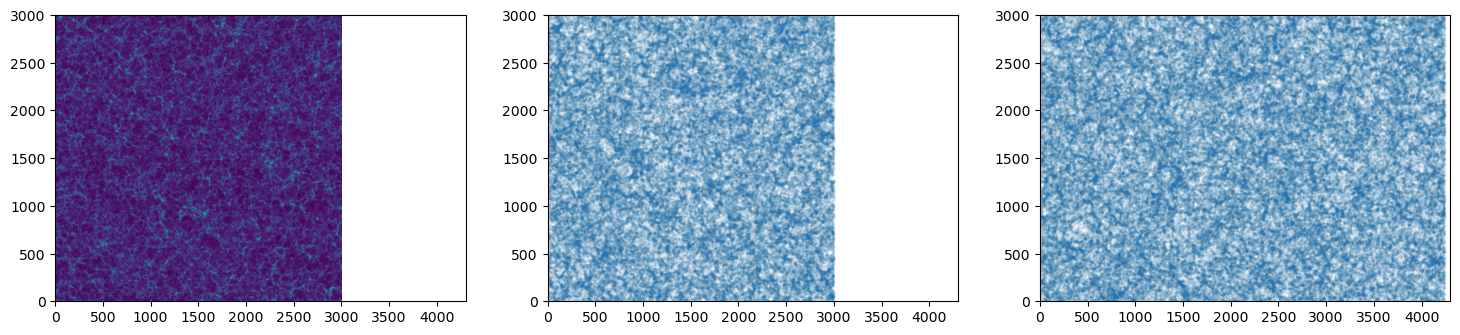

In [32]:
# plot slice
fig, axs = plt.subplots(1,3, figsize=(18,6))

axs[0].imshow(np.mean(rho[:,:,:13], axis=-1), 
              extent=[0, Lbox, 0, Lbox],
              origin='lower')
axs[0].set_xlim(0, 4.3*1e3)
axs[0].set_ylim(0, Lbox)
axs[0].set_aspect('equal')

mask = (hpos[:, -1] > 0) & (hpos[:, -1] < 100)
axs[1].scatter(hpos[mask, 0], hpos[mask, 1], s=0.1, alpha=0.1)
axs[1].set_xlim(0, 4.3*1e3)
axs[1].set_ylim(0, Lbox)
axs[1].set_aspect('equal')

mask = (hcpos[:, -1] > 0) & (hcpos[:, -1] < 100)
axs[2].scatter(hcpos[mask, 0], hcpos[mask, 1], s=0.1, alpha=0.1)
axs[2].set_xlim(0, 4.3*1e3)
axs[2].set_ylim(0, Lbox)
axs[2].set_aspect('equal')

In [7]:
from nbodykit.source.catalog import BigFileCatalog
f = BigFileCatalog('data/fastpm/fofT20B2_1.0000/LL-0.200', header='attr-v2')

/data80/mattho/anaconda3/envs/nbodykit-env/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


In [8]:
mask = (f['Position']>0) & (f['Position']<3000) # idk why there are halos out here
mask = mask.all(axis=-1)
f = f[mask]

# calculate masses from particle counts
mp = float(f.attrs['M0'] * 1e10)
Ms = mp*f['Length']
f['Mass'] = Ms
f.attrs['BoxSize'] = (3000,3000,3000)

/data80/mattho/anaconda3/envs/nbodykit-env/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


In [9]:
pmpos = f['Position'].compute()
pmm = f['Mass'].compute()

/data80/mattho/anaconda3/envs/nbodykit-env/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


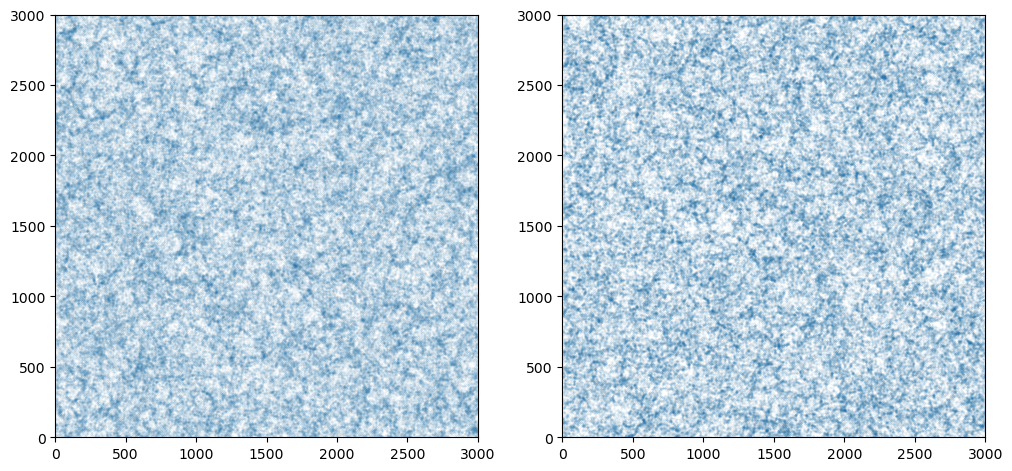

In [33]:
# compare hpos and pmpos
fig, axs = plt.subplots(1,2, figsize=(12,6))

mask = (hpos[:, -1] > 0) & (hpos[:, -1] < 100)
mask *= hmass > 13
axs[0].scatter(hpos[mask, 0], hpos[mask, 1], s=0.1, alpha=0.1)
axs[0].set_xlim(0, Lbox)
axs[0].set_ylim(0, Lbox)
axs[0].set_aspect('equal')

mask = (pmpos[:, -1] > 0) & (pmpos[:, -1] < 100)
mask *= pmm > 10**13
axs[1].scatter(pmpos[mask, 0], pmpos[mask, 1], s=0.1, alpha=0.1)
axs[1].set_xlim(0, Lbox)
axs[1].set_ylim(0, Lbox)
axs[1].set_aspect('equal')


(9636634, 9749693)

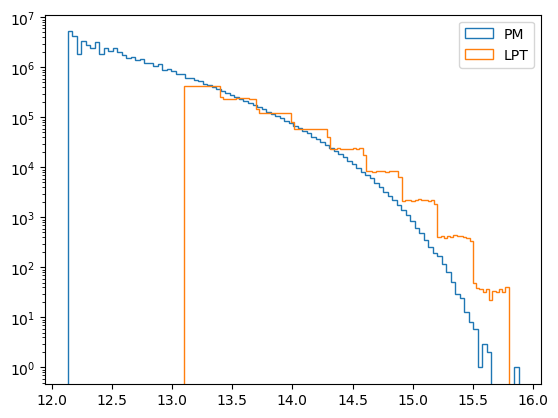

In [34]:
plt.semilogy()
plt.hist(np.log10(pmm), bins=100, histtype='step', label='PM')
plt.hist((hmass), bins=100, histtype='step', label='LPT')
plt.legend()
np.sum(pmm > 10**13), np.sum(hmass > 13)

## apply_hod

In [35]:
seed = 0
hod = np.load(pjoin(source_dir, 'hod', f'hod{seed}_pos.npy'))

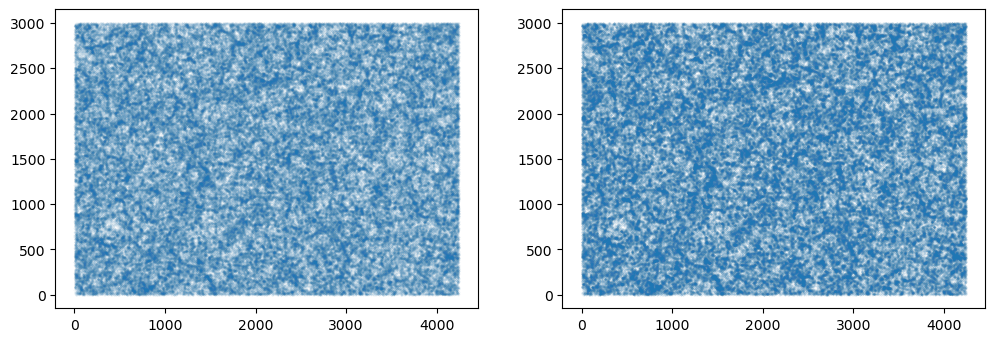

In [36]:
# plot hod comparison
fig, axs = plt.subplots(1,2, figsize=(12,6))

mask = (hcpos[:, -1] > 0) & (hcpos[:, -1] < 100)
axs[0].scatter(hcpos[mask, 0], hcpos[mask, 1], s=0.1, alpha=0.1)
axs[0].set_aspect('equal')

mask = (hod[:, -1] > 0) & (hod[:, -1] < 100)
axs[1].scatter(hod[mask, 0], hod[mask, 1], s=0.1, alpha=0.1)
axs[1].set_aspect('equal')

## apply_survey

In [50]:
# load simulation
rdz = np.load(pjoin(source_dir, 'obs', f'rdz{seed}.npy'))
pos = np.array(nblab.transform.SkyToCartesian(*rdz.T, cosmo=cosmo))

In [51]:
# load survey
def load_galaxies(fname, fields):
    with fits.open(fname) as hdul:
        gals = np.array([hdul[1].data[x] for x in fields]).T
        gals = pd.DataFrame(gals, columns=fields)    
    return gals
# load data
fname = 'data/obs/galaxy_DR12v5_CMASSLOWZTOT_North.fits'
fields = ['RA','DEC','Z',
          'WEIGHT_SYSTOT','WEIGHT_NOZ','WEIGHT_CP']
cmass = load_galaxies(fname, fields)
mask = BOSS_angular(cmass['RA'], cmass['DEC'])
mask *= BOSS_redshift(cmass['Z'])
cmass = cmass[mask].reset_index(drop=True)

crdz = np.stack([cmass['RA'], cmass['DEC'], cmass['Z']], axis=-1)
cpos = nblab.transform.SkyToCartesian(*crdz.T, cosmo=cosmo)
cpos = np.array(cpos.compute())

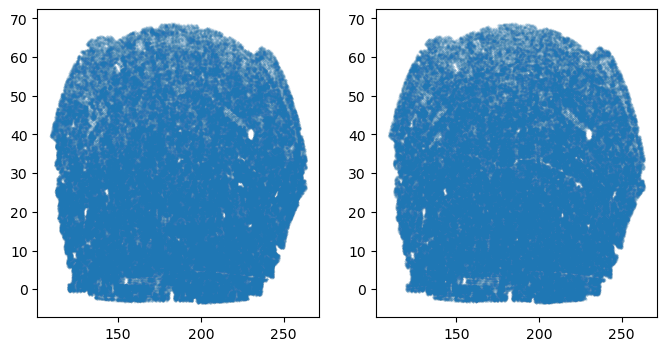

In [52]:
# plot sky-projection
fig, axs = plt.subplots(1,2, figsize=(8,4))

axs[0].scatter(rdz[:, 0], rdz[:, 1], s=0.1, alpha=0.1)
axs[1].scatter(crdz[:, 0], crdz[:, 1], s=0.1, alpha=0.1)

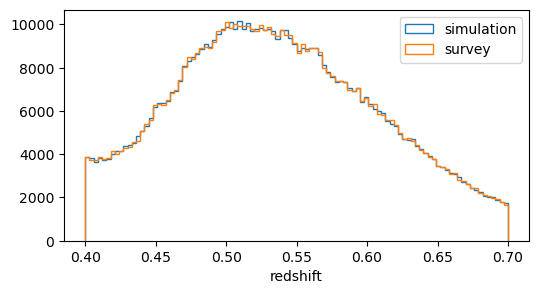

In [53]:
# plot redshift distribution on top of each other
fig, axs = plt.subplots(1,1, figsize=(6,3))

axs.hist(rdz[:, 2], bins=100, histtype='step', label='simulation')
axs.hist(crdz[:, 2], bins=100, histtype='step', label='survey')
axs.set_xlabel('redshift')
axs.legend()

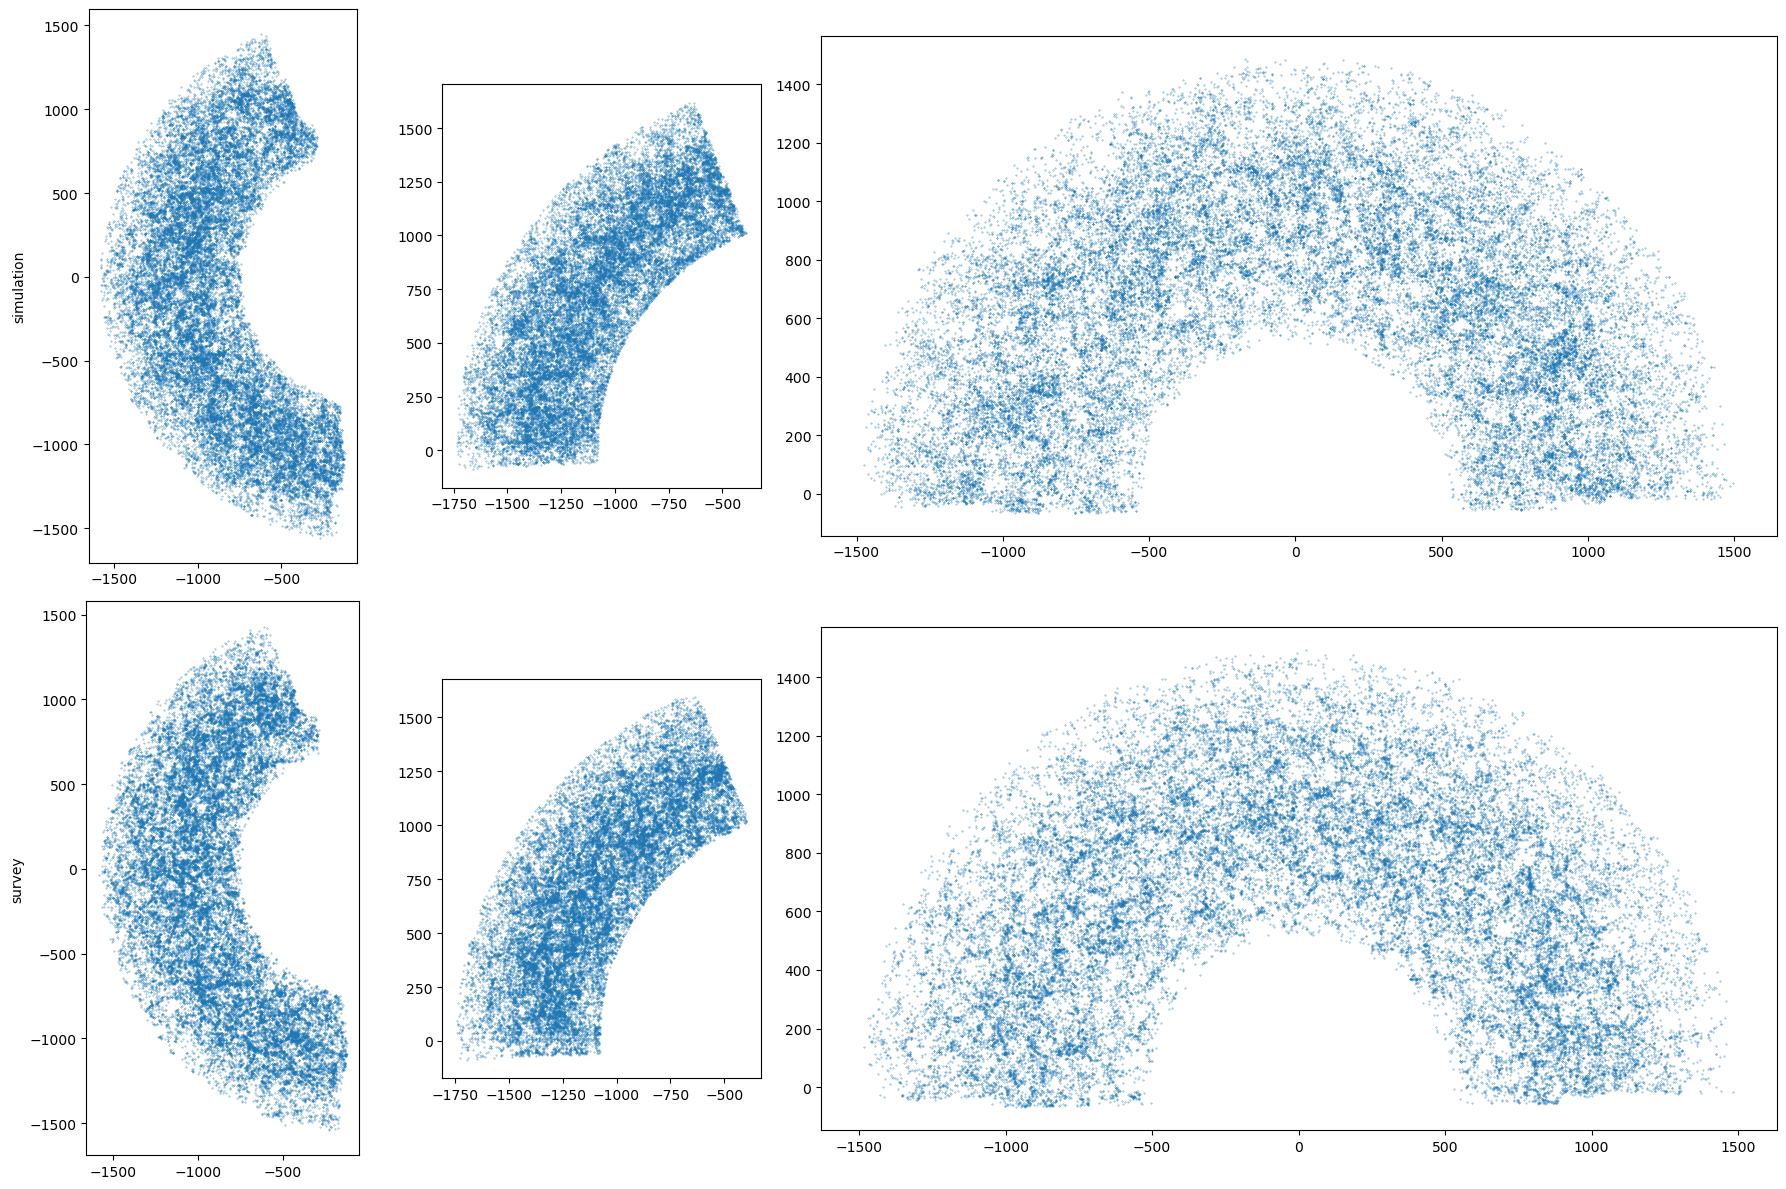

In [66]:
def slice_mask(x):
    mima = x.min(), x.max()
    dx = (mima[1] - mima[0])*0.02
    mid = np.mean(mima)
    return (x > mid - dx) & (x < mid + dx)

# plot cpos from all axes
fig, axs = plt.subplots(2,3, figsize=(18,12), gridspec_kw={'width_ratios':[1,1,3]})

for i, ipos in enumerate([pos, cpos]):
    mask = slice_mask(ipos[:, 2])
    axs[i,0].scatter(ipos[mask, 0], ipos[mask, 1], s=0.1, alpha=0.75)
    axs[i,0].set_aspect('equal')

    mask = slice_mask(ipos[:, 1])
    axs[i,1].scatter(ipos[mask, 0], ipos[mask, 2], s=0.1, alpha=0.75)
    axs[i,1].set_aspect('equal')

    mask = slice_mask(ipos[:, 0])
    axs[i,2].scatter(ipos[mask, 1], ipos[mask, 2], s=0.1, alpha=0.75)
    axs[i,2].set_aspect('equal')

    if i==0:
        axs[i,0].set_ylabel('simulation')
    else:
        axs[i,0].set_ylabel('survey')

plt.tight_layout()

In [42]:
from scipy.spatial.transform import Rotation as R
r = R.from_quat([0, 0, np.sin(np.pi/4), np.cos(np.pi/4)]).as_matrix()
hcposR = hcpos@r
hcposR -= (hcposR.max(axis=0) + hcposR.min(axis=0))/2
hcposR += [-924.42673929,  -44.04583784,  750.98510587]

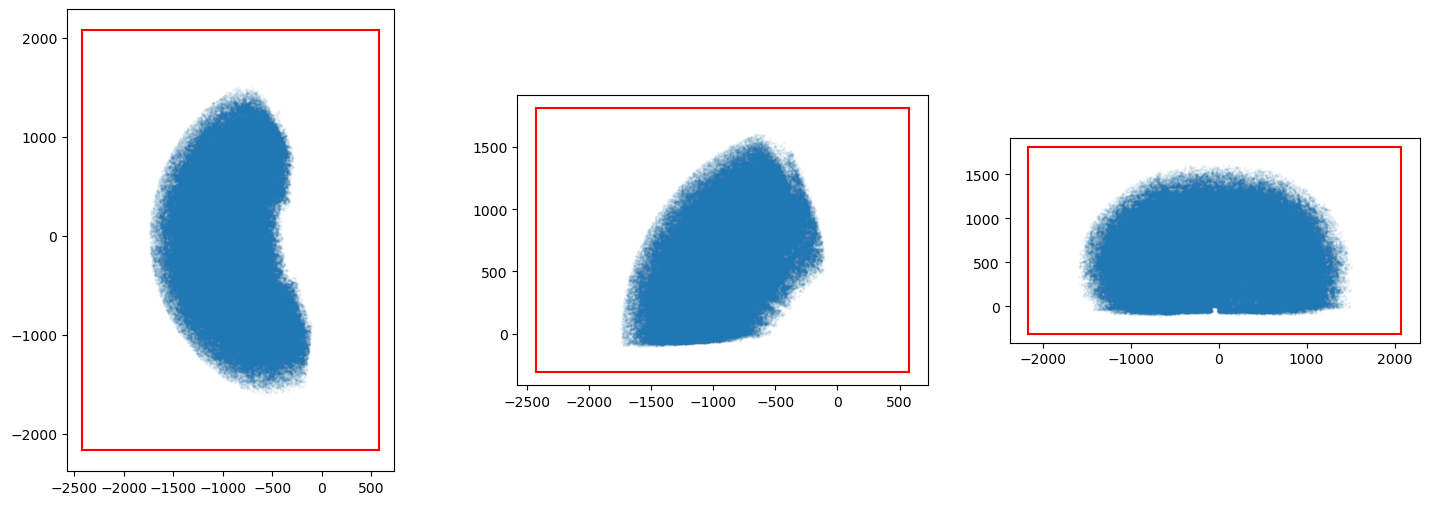

In [44]:
# plot positions from each axis
mins, maxs = hcposR.min(axis=0), hcposR.max(axis=0)
def plot_rectangle(min_x, min_y, max_x, max_y, ax, c='r'):
    ax.plot([min_x, min_x], [min_y, max_y], c=c)
    ax.plot([min_x, max_x], [min_y, min_y], c=c)
    ax.plot([max_x, max_x], [min_y, max_y], c=c)
    ax.plot([min_x, max_x], [max_y, max_y], c=c)

fig, axs = plt.subplots(1,3, figsize=(18,6))

axs[0].scatter(cpos[:, 0], cpos[:, 1], s=0.1, alpha=0.1)
plot_rectangle(mins[0], mins[1], maxs[0], maxs[1], axs[0])
axs[0].set_aspect('equal')

axs[1].scatter(cpos[:, 0], cpos[:, 2], s=0.1, alpha=0.1)
plot_rectangle(mins[0], mins[2], maxs[0], maxs[2], axs[1])
axs[1].set_aspect('equal')

axs[2].scatter(cpos[:, 1], cpos[:, 2], s=0.1, alpha=0.1)
plot_rectangle(mins[1], mins[2], maxs[1], maxs[2], axs[2])
axs[2].set_aspect('equal')

## calc_Pk

In [76]:
# load simulation Pk
source_dir = pjoin(
        './data', 'borg-quijote/latin_hypercube_HR-L3000-N384',
        f'{lhid}', 'Pk')
outpath = pjoin(source_dir, f'Pk{seed}.npz')
out = np.load(outpath)
k_sim, p0k_sim, p2k_sim, p4k_sim = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']

# load survey Pk
source_dir = 'data/obs'
outpath = pjoin(source_dir, 'Pk', 'Pk.npz')
out = np.load(outpath)
k_sur, p0k_sur, p2k_sur, p4k_sur = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']

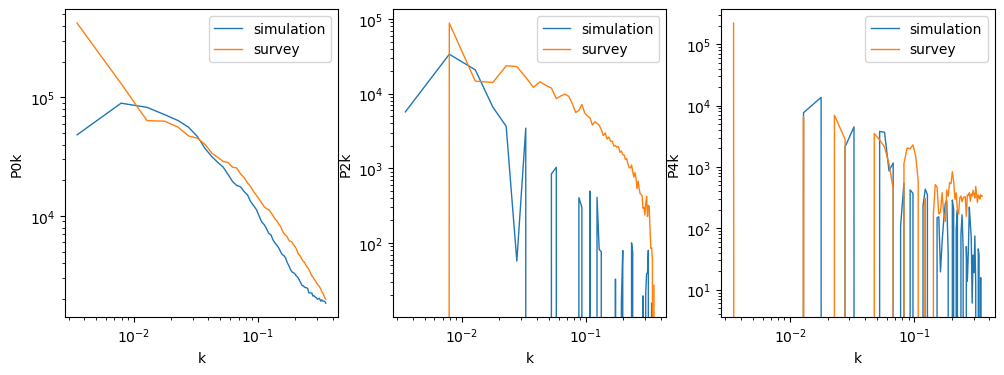

In [80]:
# plot simulation and survey Pk
fig, axs = plt.subplots(1,3, figsize=(12,4))

axs[0].plot(k_sim, p0k_sim, label='simulation', lw=1)
axs[0].plot(k_sur, p0k_sur, label='survey', lw=1)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('k')
axs[0].set_ylabel('P0k')
axs[0].legend()

axs[1].plot(k_sim, p2k_sim, label='simulation', lw=1)
axs[1].plot(k_sur, p2k_sur, label='survey', lw=1)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('k')
axs[1].set_ylabel('P2k')
axs[1].legend()

axs[2].plot(k_sim, p4k_sim, label='simulation', lw=1)
axs[2].plot(k_sur, p4k_sur, label='survey', lw=1)
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('k')
axs[2].set_ylabel('P4k')
axs[2].legend()


# Scratch